# Install LXML, Geopy and Import librabries

In [2]:
pip install lxml

     |████████████████████████████████| 5.8MB 1.1MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install geopy

     |████████████████████████████████| 102kB 2.9MB/s ta 0:00:011
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/99/45/d1/14954797e2a976083182c2e7da9b4e924509e59b6e5c661061
Successfully built geographiclib
Note: you may need to restart the kernel to use updated packages.


In [57]:
import pandas as pd
import numpy as np
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

In [5]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# import k-means from clustering stage
from sklearn.cluster import KMeans
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
print('Folium installed and imported!')

Folium installed and imported!


# Set the map coordinates

In [7]:
Toronto_address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(Toronto_address)
Toronto_latitude = location.latitude
Toronto_longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(Toronto_latitude, Toronto_longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


# Scrape website and wrangle data into useable information

In [8]:
P = pd.read_html("https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods")

In [9]:
df8 = P[1]

In [10]:
df9 = df8.drop(columns=['FM', 'Census Tracts', '% Change in Population since 2001', 'Land area (km2)', '% Renters', 'Second most common language (after English) by name', 'Second most common language (after English) by percentage', 'Map'])

In [11]:
df10 = df9.drop([df9.columns[4]],  axis='columns')
df10.rename(columns={'Name':'Neighbourhood'}, inplace=True)
df10.rename(columns={'Density (people/km2)':'Density'}, inplace=True)

In [12]:
df11 = df10.drop([0], axis = 0)

In [13]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [14]:
df12 = df11.drop([28], axis = 0)
df13 = df12.drop([39], axis = 0)
df14 = df13.drop([60], axis = 0)
df15 = df14.drop([72], axis = 0)
df16 = df15.drop([77], axis = 0)
df17 = df16.drop([79], axis = 0)
df18 = df17.drop([119], axis = 0)
df19 = df18.drop([124], axis = 0)
df20 = df19.drop([128], axis = 0)

# Pull longitude and latitude and merge into dataframe

In [15]:
df_geo = []

In [16]:
for i, row in df20.iterrows():
    Neighbourhood = df20.Neighbourhood[i]
    address = df20.Neighbourhood[i] + ', Toronto'
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    df_geo.append((Neighbourhood, latitude, longitude))

In [17]:
df_geo1 = pd.DataFrame(df_geo, columns=('Neighbourhood', 'Latitude', 'Longitude'))

In [18]:
df_Final = pd.merge(df20, df_geo1, on='Neighbourhood')

# Connect to Foursquare API and pull venue information

In [100]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
CLIENT_ID = 'ABWQM3DKQK52E5U0WXC1DZTLER2EH5E4TTUIDXRZ0WPYIHWS' # your Foursquare ID
CLIENT_SECRET = 'SXMTOWIRWREWOG20FPBIKS1HJTKCZW5FNGVQIFX22YHE3K1M' # your Foursquare Secret
VERSION = '20180604'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
radius = 6500 # define radius

Your credentails:
CLIENT_ID: ABWQM3DKQK52E5U0WXC1DZTLER2EH5E4TTUIDXRZ0WPYIHWS
CLIENT_SECRET:SXMTOWIRWREWOG20FPBIKS1HJTKCZW5FNGVQIFX22YHE3K1M


In [101]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [102]:
# type your answer here

Toronto_venues = getNearbyVenues(names=df_Final['Neighbourhood'],
                                   latitudes=df_Final['Latitude'],
                                   longitudes=df_Final['Longitude']
                                  )
print ("Done!")

Done!


In [103]:
unique = Toronto_venues.groupby(["Venue Category"],as_index=False, sort=False).agg(", ".join)
Businesses = unique.drop(columns=['Neighbourhood', "Venue"])
Businesses.rename(columns={'Venue Category':'Types of Businesses'}, inplace=True)

In [104]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighbourhood'] = Toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

In [105]:
Toronto_grouped = Toronto_onehot.groupby('Neighbourhood').sum().reset_index()

In [106]:
Toronto_Final = pd.merge(df_Final, Toronto_grouped, on='Neighbourhood')

In [107]:
Toronto_Final.shape

(163, 321)

In [108]:
Toronto_Final.head()

,Neighbourhood,Population,Density,Average Income,Latitude,Longitude,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,44577,3580,25750,43.785353,-79.278549,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Alderwood,11656,2360,35239,43.601717,-79.545232,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Alexandra Park,4355,13609,19687,43.650758,-79.404298,0,0,0,1,...,0,0,1,0,0,1,0,0,0,1
3,Allenby,2513,4333,245592,43.711351,-79.553424,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,Amesbury,17318,4934,27546,43.706162,-79.483492,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [95]:
All_Business_Count = Toronto_Final

In [109]:
All_Business_Count1 = All_Business_Count.drop(columns=['Neighbourhood','Population', 'Density', 'Average Income', 'Latitude', 'Longitude'])
All_Business_Count2 = All_Business_Count1.sum()

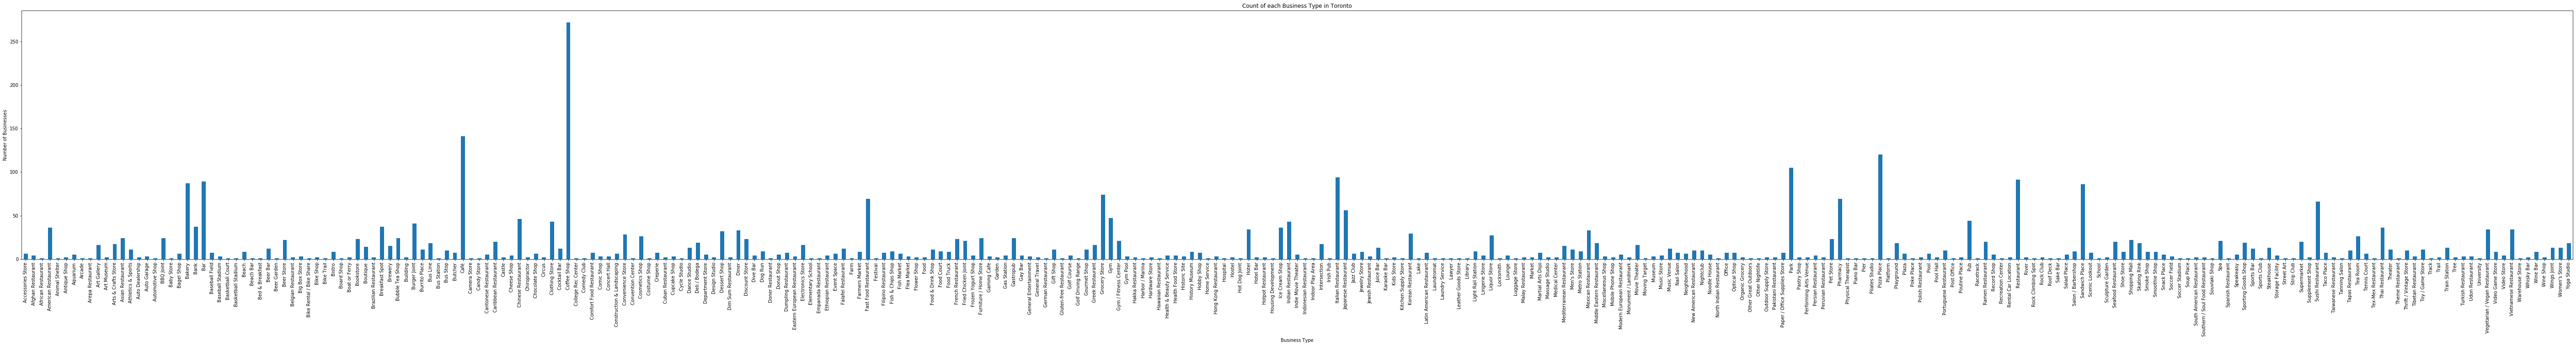

In [127]:
All_Business_Count2.plot(kind='bar', figsize=(100, 10))

plt.xlabel('Business Type') # add to x-label to the plot
plt.ylabel('Number of Businesses') # add y-label to the plot
plt.title('Count of each Business Type in Toronto') # add title to the plot

plt.show()

In [123]:
plt.savefig('Number_of_Business.png')

<Figure size 432x288 with 0 Axes>

In [111]:
L_Num_Business = pd.DataFrame(All_Business_Count2.nlargest(50))
L_Num_Business.rename(columns={0:'Count'}, inplace=True)
L_Num_Business.head(10)

,Count
Coffee Shop,272
Café,141
Pizza Place,120
Park,105
Italian Restaurant,94
Restaurant,91
Bar,89
Bakery,87
Sandwich Place,86
Grocery Store,74


In [121]:
S_Num_Business = pd.DataFrame(All_Business_Count2.nsmallest(125))
S_Num_Business.rename(columns={0:'Count'}, inplace=True)
S_Num_Business.head(15)

,Count
African Restaurant,1
Animal Shelter,1
Arcade,1
Arepa Restaurant,1
Automotive Shop,1
Baby Store,1
Basketball Court,1
Basketball Stadium,1
Beach Bar,1
Bed & Breakfast,1


# Select your business, the focus of your search, and the number of reccomendations you would like.

Run the following code, and input the Business Type, Focus of the search, and Number of reccomendations you would like

In [289]:
print_full(Businesses) # Double click for list of all types of businesses

                 Types of Businesses
0                   Asian Restaurant
1                 Chinese Restaurant
2                        Coffee Shop
3                  Korean Restaurant
4               Hong Kong Restaurant
5              Vietnamese Restaurant
6               Cantonese Restaurant
7                Rental Car Location
8                      Train Station
9                        Pizza Place
10                               Pub
11                               Gym
12                    Sandwich Place
13                      Skating Rink
14                          Pharmacy
15                      Dessert Shop
16                        Food Court
17               Filipino Restaurant
18     Vegetarian / Vegan Restaurant
19                               Bar
20                       Art Gallery
21               Japanese Restaurant
22                              Park
23               Arts & Crafts Store
24                        Restaurant
25                      Cocktail Bar
2

In [148]:
Business_Type = "Gym" # What type of busines are you looking for a location for. 
Focus = "Population" # What do you want to be the focus on the search, Population? Density? or Average Income?
Size = 10 # The number of reccomedations you would like to see.

In [149]:
Business_Count = Toronto_Final[['Neighbourhood', 'Population', 'Density','Average Income','Latitude','Longitude', Business_Type]]

In [150]:
Zero_Business_Count = Business_Count[Business_Count[Business_Type] == min(Business_Count[Business_Type])]

In [151]:
Suggestion = Zero_Business_Count.nlargest(Size, Focus)

In [152]:
Suggestion.head(Size)

,Neighbourhood,Population,Density,Average Income,Latitude,Longitude,Gym
105,Old East York,52220,6577,33172,43.691339,-79.327821,0
46,Elia (Jane and Finch),48003,6267,22691,43.757253,-79.517697,0
78,L'Amoreaux,45862,6414,26375,43.799003,-79.305967,0
0,Agincourt,44577,3580,25750,43.785353,-79.278549,0
90,Malvern,44324,5003,25677,43.809196,-79.221701,0
156,Willowdale,43144,5618,39895,43.775356,-79.416686,0
40,Downsview,36613,2270,26751,43.749299,-79.462248,0
100,Newtonbrook,36046,4110,33428,43.793886,-79.425679,0
128,Smithfield,34996,5426,24387,43.631184,-79.485667,0
48,Fairbank,34121,7720,28403,43.695689,-79.450310,0


In [153]:
Suggestion_Map = folium.Map(location=[Toronto_latitude + 0.07, Toronto_longitude ], zoom_start=11)
num = 1

# add markers to map
for lat, lng, neigh, pop, den, inc in zip(Suggestion['Latitude'],Suggestion['Longitude'],Suggestion['Neighbourhood'],Suggestion['Population'],Suggestion['Density'],Suggestion['Average Income']):
    label = '#{}, {}, Population: {}, Density: {}/km2, Average Income: ${}'.format(num, neigh, pop, den, inc)
    label = folium.Popup(label, parse_html=True)
    if num == 1:
        colour = 'orange'
    else:
        colour ='#3186cc'
        
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='blue',
        fill=True,
        fill_color = colour,
        fill_opacity=0.7,
        parse_html=False).add_to(Suggestion_Map)
    
    num = num + 1
Suggestion_Map